In [ ]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

data = pd.read_csv("MRCFS.csv", low_memory=False)


columns = [
    'CONTROL',                          # Public/Private university
    'CREDDESC',                         # Bacherlors/Master/or else
    'CREDLEV',                          # Years of degree
    'CIPDESC',                          # Type of course


    'EARN_NOPELL_WNE_MDN_5YR',          # Median earning w/o pell grants after 5yr
    'EARN_PELL_WNE_MDN_5YR'             # Median earning w/ pell grants after 5yr
]

data = data[columns].replace("PS", pd.NA).dropna()

X = data.drop(columns=['EARN_NOPELL_WNE_MDN_5YR', 'EARN_PELL_WNE_MDN_5YR'])
y_pell = data['EARN_PELL_WNE_MDN_5YR']
y_no_pell = data['EARN_NOPELL_WNE_MDN_5YR']

X_train, X_test, y_train_pell, y_test_pell = train_test_split(X, y_pell, test_size=0.2, random_state=42)
_, _, y_train_no_pell, y_test_no_pell = train_test_split(X, y_no_pell, test_size=0.2, random_state=42)

categorical_data = ['CIPDESC', 'CREDDESC', 'CONTROL']

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder.fit(X_train[categorical_data])

X_train_cat = encoder.transform(X_train[categorical_data])
X_test_cat = encoder.transform(X_test[categorical_data])

encoded_colnames = encoder.get_feature_names_out(categorical_data)

X_train_cat = pd.DataFrame(X_train_cat, columns=encoded_colnames, index=X_train.index)
X_test_cat = pd.DataFrame(X_test_cat, columns=encoded_colnames, index=X_test.index)

X_train_num = X_train.drop(columns=categorical_data)
X_test_num = X_test.drop(columns=categorical_data)

X_train_final = pd.concat([X_train_num, X_train_cat], axis=1).astype(float)
X_test_final = pd.concat([X_test_num, X_test_cat], axis=1).astype(float)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# PELL
model_pell = RandomForestRegressor(n_estimators=100, random_state=42)
model_pell.fit(X_train_final, y_train_pell)

y_pred_pell = model_pell.predict(X_test_final)

# NO PELL
model_nopell = RandomForestRegressor(n_estimators=100, random_state=42)
model_nopell.fit(X_train_final, y_train_no_pell)

y_pred_nopell = model_nopell.predict(X_test_final)


print("Pell R²:", r2_score(y_test_pell, y_pred_pell))
print("No-Pell R²:", r2_score(y_test_no_pell, y_pred_nopell))

print("")

print("Pell RMSE:", np.sqrt(mean_squared_error(y_test_pell, y_pred_pell)))
print("No-Pell RMSE:", np.sqrt(mean_squared_error(y_test_no_pell, y_pred_nopell)),"\n")


from sklearn.metrics import mean_absolute_error


print("Pell MAE:", mean_absolute_error(y_test_pell, y_pred_pell))
print("No-Pell MAE:", mean_absolute_error(y_test_no_pell, y_pred_nopell),"\n")

print("Pell/No-Pell income Gap: ", np.mean(y_pred_nopell - y_pred_pell),"\n")

print("Pell income: ", np.mean(y_pred_pell))
print("No-Pell income: ", np.mean(y_pred_nopell))

Pell R²: 0.719727304735223
No-Pell R²: 0.7026676397147168

Pell RMSE: 15851.992531234646
No-Pell RMSE: 16266.115177333868 

Pell MAE: 9400.163254489004
No-Pell MAE: 9914.556032693861 

Pell/No-Pell income Gap:  5138.541009753505 

Pell income:  66082.25334578089
No-Pell income:  71220.7943555344


/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


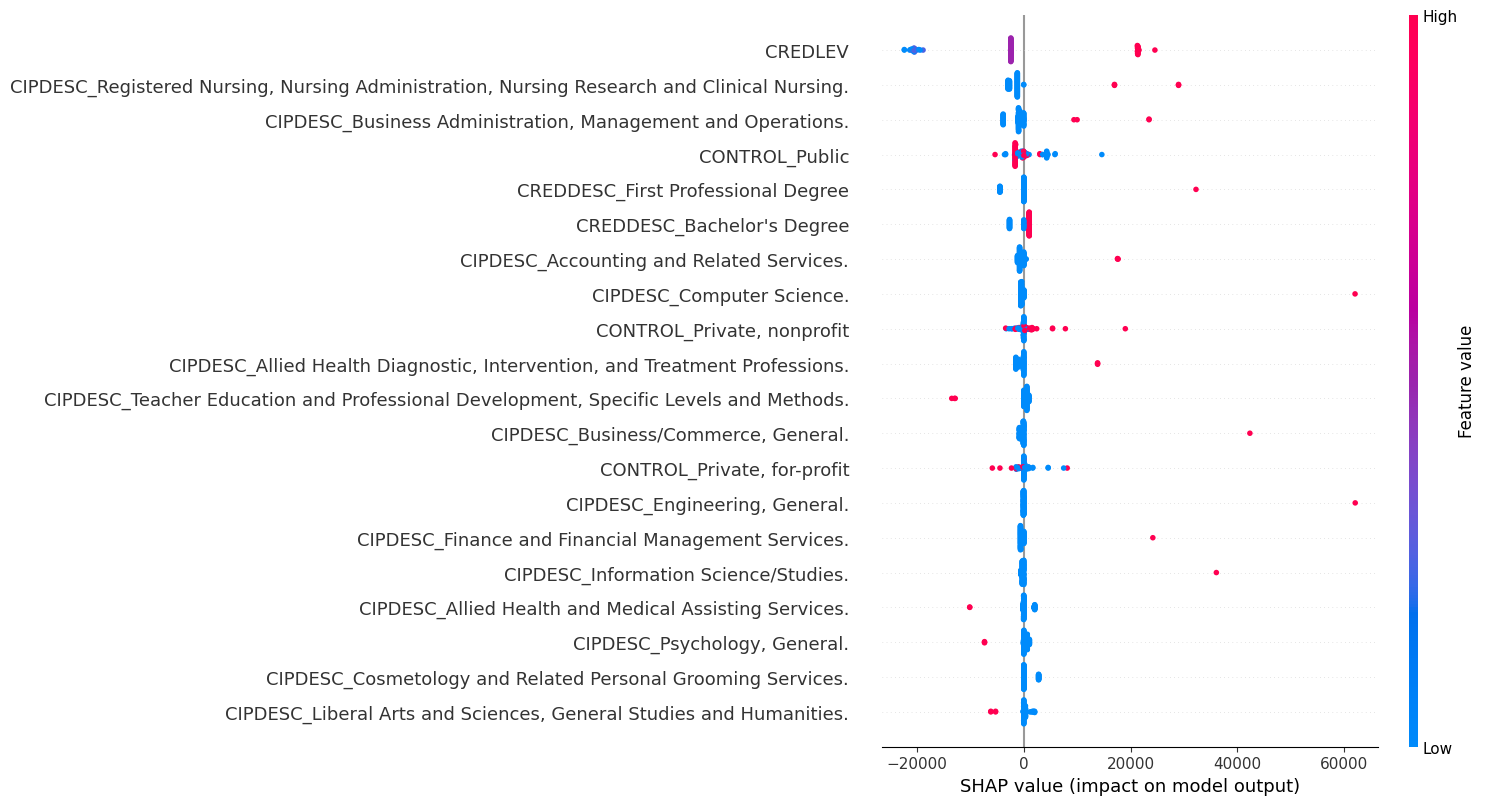

/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


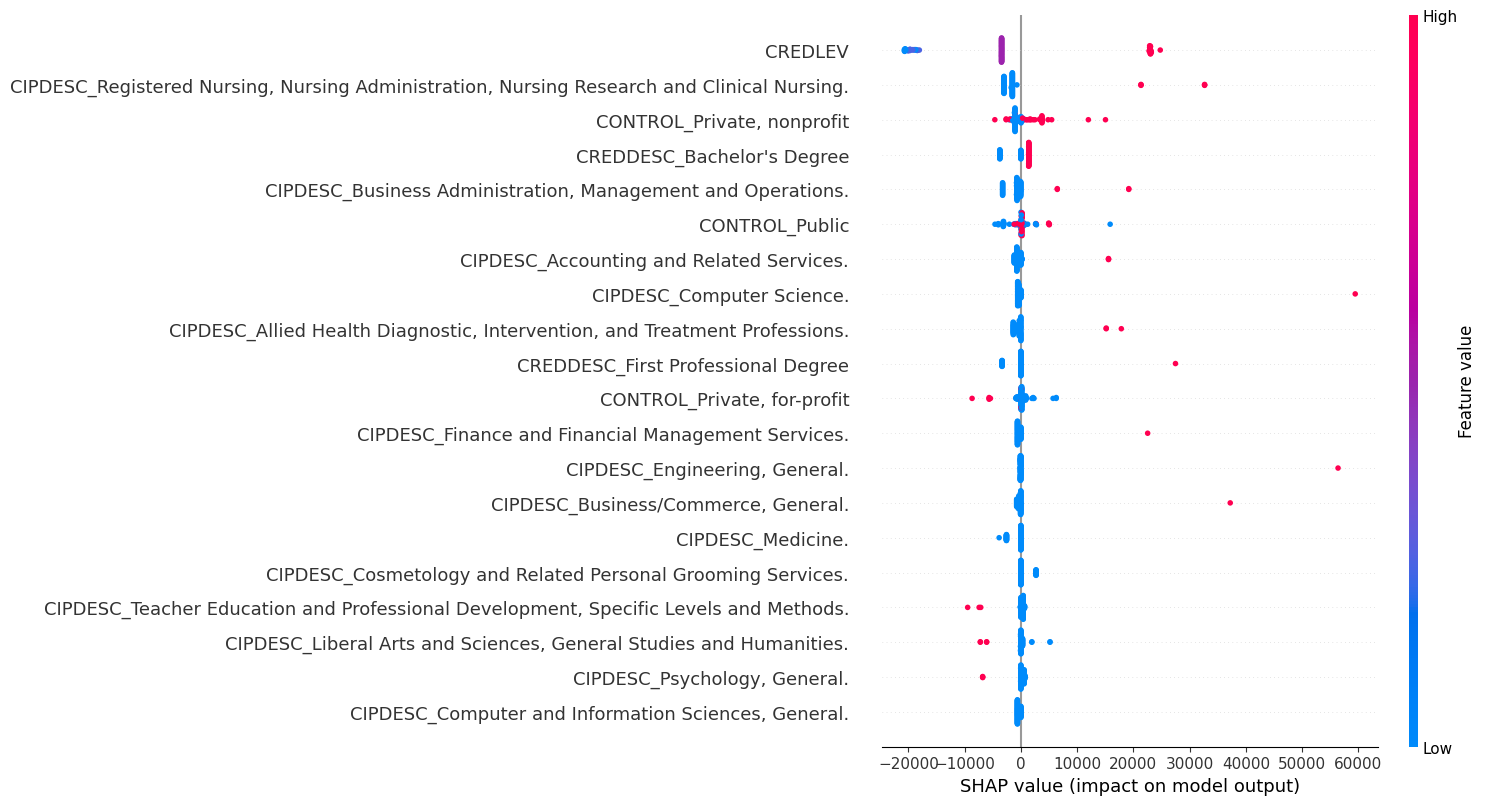

In [ ]:
import shap
X_test_sample = X_test_final.sample(100, random_state=42)

ex = shap.TreeExplainer(model_nopell)
shap_values = ex.shap_values(X_test_sample, approximate=True)

shap.summary_plot(shap_values, X_test_sample)



ex1 = shap.TreeExplainer(model_pell)
shap_values2 = ex1.shap_values(X_test_sample, approximate=True)

shap.summary_plot(shap_values2, X_test_sample)

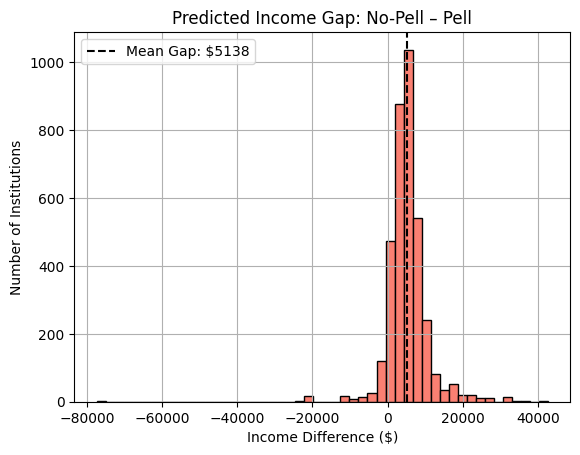

In [ ]:
import matplotlib.pyplot as plt

plt.hist(y_pred_nopell - y_pred_pell, bins=50, color='salmon', edgecolor='black')
plt.title("Predicted Income Gap: No-Pell – Pell")
plt.xlabel("Income Difference ($)")
plt.ylabel("Number of Institutions")
plt.axvline(np.mean(y_pred_nopell - y_pred_pell), color='black', linestyle='--', label=f"Mean Gap: ${int(np.mean(y_pred_nopell - y_pred_pell))}")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
data['EARN_NOPELL_WNE_MDN_5YR'] = pd.to_numeric(data['EARN_NOPELL_WNE_MDN_5YR'], errors='coerce')
data['EARN_PELL_WNE_MDN_5YR'] = pd.to_numeric(data['EARN_PELL_WNE_MDN_5YR'], errors='coerce')

data['INCOME_GAP'] = data['EARN_NOPELL_WNE_MDN_5YR'] - data['EARN_PELL_WNE_MDN_5YR']
gap_data = data[['CONTROL', 'CREDDESC', 'CREDLEV', 'CIPDESC', 'INCOME_GAP']].dropna()

X_gap = gap_data.drop(columns=['INCOME_GAP'])
y_gap = gap_data['INCOME_GAP']

X_train, X_test, y_train, y_test = train_test_split(X_gap, y_gap, test_size=0.2, random_state=42)

# One-hot encode all categoricals
categorical_cols = ['CONTROL', 'CREDDESC', 'CIPDESC']

encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
encoder.fit(X_train[categorical_cols])

X_train_encoded = pd.DataFrame(
    encoder.transform(X_train[categorical_cols]),
    columns=encoder.get_feature_names_out(categorical_cols),
    index=X_train.index
)

X_test_encoded = pd.DataFrame(
    encoder.transform(X_test[categorical_cols]),
    columns=encoder.get_feature_names_out(categorical_cols),
    index=X_test.index
)

# Drop encoded categoricals and combine
X_train_final = pd.concat([X_train.drop(columns=categorical_cols), X_train_encoded], axis=1).astype(float)
X_test_final = pd.concat([X_test.drop(columns=categorical_cols), X_test_encoded], axis=1).astype(float)
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

model_gap = RandomForestRegressor(n_estimators=100, random_state=42)
model_gap.fit(X_train_final, y_train)

y_pred_gap = model_gap.predict(X_test_final)

print("Gap R²:", r2_score(y_test, y_pred_gap))
print("Gap RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_gap)))
print("Gap MAE:", mean_absolute_error(y_test, y_pred_gap))

Gap R²: 0.13051623636721743
Gap RMSE: 9508.156013732547
Gap MAE: 6459.508646720157


/usr/local/lib/python3.11/dist-packages/shap/plots/_beeswarm.py:1150: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


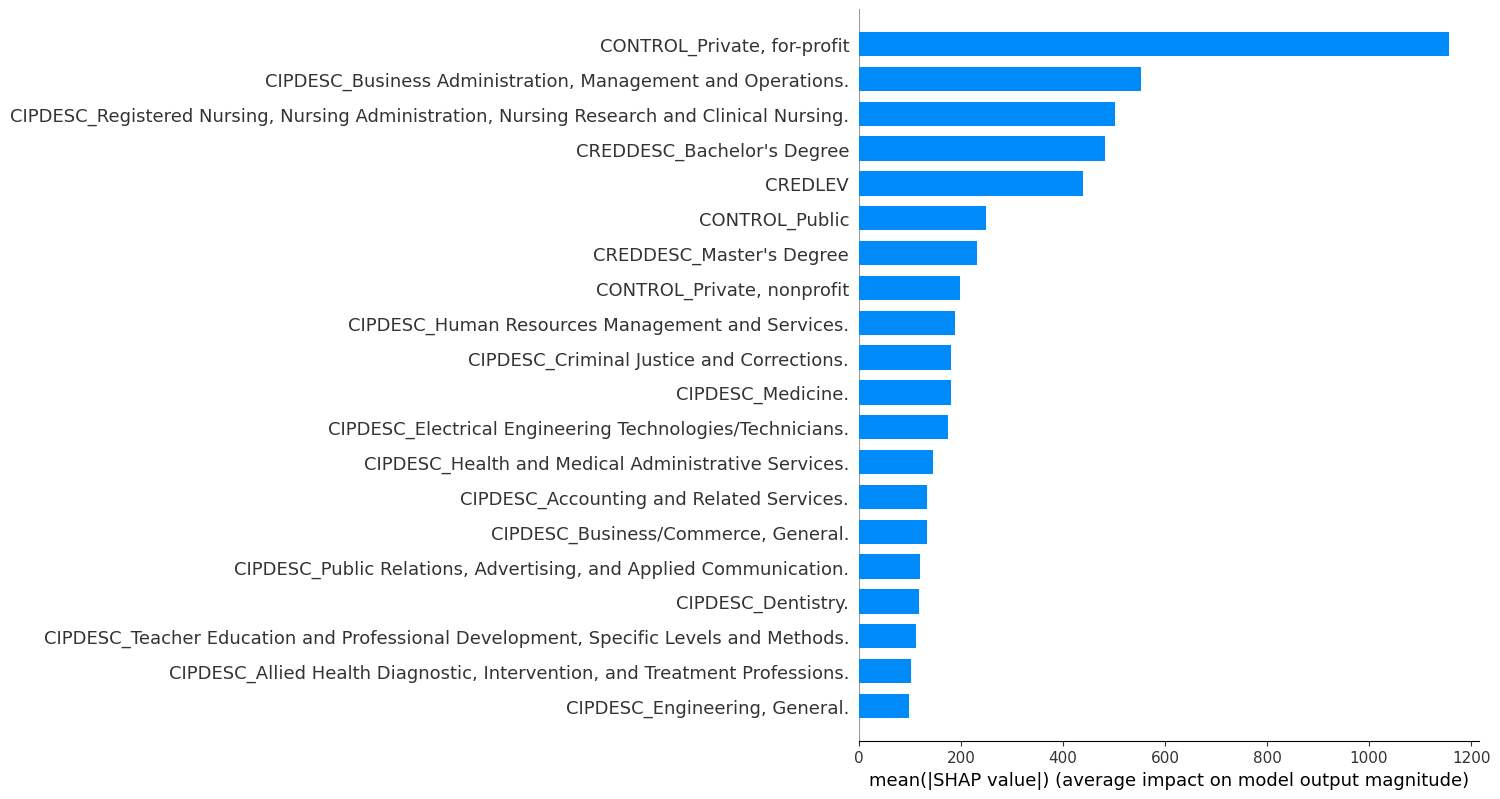

In [ ]:
X_test_sample_gap = X_test_final.sample(100, random_state=42)

explainer = shap.TreeExplainer(model_gap)

shap_values = explainer.shap_values(X_test_sample_gap, approximate=True)

shap.summary_plot(shap_values, X_test_sample_gap, plot_type="bar")